<a href="https://colab.research.google.com/github/namoshi/dl_intro/blob/master/MLP_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Multi-layered Perceptron (MLP)

Classification of handwritten numbers (MNIST) by MLP

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dsets
import torchvision.transforms as transforms

In [3]:
# load MNIST data
train_Dataset = dsets.MNIST(
      root='./data',  # rootで指定したフォルダーを作成して生データを展開
      train=True,  # 学習かテストかの選択
      transform=transforms.ToTensor(),  # PyTroch のテンソルに変換
      download=True)  # ダウンロードするかどうかの選択

test_dataset = dsets.MNIST(
      root='./data',  
      train=False, 
      transform=transforms.ToTensor(),
      download=True)

train_dataset, valid_dataset = torch.utils.data.random_split(  # データセットの分割
      train_Dataset,   # 分割するデータセット
      [48000, 12000])  # 分割数
 
print('train_dataset = ', len(train_dataset))
print('valid_dataset = ', len(valid_dataset))  
print('test_dataset = ', len(test_dataset))


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!
train_dataset =  48000
valid_dataset =  12000
test_dataset =  10000


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [4]:
# set data loader
train_loader = torch.utils.data.DataLoader(
      dataset=train_dataset,  # データセットの指定
      batch_size=64,  # ミニバッチの指定
      shuffle=True,  # シャッフルするかどうかの指定
      num_workers=2)  # コアの数

valid_loader = torch.utils.data.DataLoader(
      dataset=valid_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)

test_loader = torch.utils.data.DataLoader(
      dataset=test_dataset,
      batch_size=64, 
      shuffle=False,
      num_workers=2)


In [5]:
# Multi Layer Perceptron Network
class MLPNet (nn.Module):
    def __init__(self):
        super(MLPNet, self).__init__()
        self.fc1 = nn.Linear(28 * 28 * 1, 128)   
        self.fc2 = nn.Linear(128, 10)
        self.dropout = nn.Dropout2d(0.4)
        
    def forward(self, x):
        y = torch.relu(self.fc1(x))
#        y = torch.sigmoid(self.fc1(x))
#        y = torch.tanh(self.fc1(x))
#        y = self.dropout1(y)
        z = self.fc2(y)
        return z

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
net = MLPNet().to(device)
print(device)

# optimizing
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=0.01)
optimizer = optim.AdamW(net.parameters(), lr=0.01, weight_decay=0.01)


cuda


In [6]:
###  training
print ('training start ...')
num_epochs = 50   

# initialize list for plot graph after training
train_loss_list, train_acc_list, val_loss_list, val_acc_list = [], [], [], []

for epoch in range(num_epochs):
    # initialize each epoch
    train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0
    
    # ======== train_mode (Backprop) ======
    net.train()
    for i, (images, labels) in enumerate(train_loader):  # get mini batch samples
        #viewで28×28×１画像を１次元に変換し、deviceへ転送
        images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
        optimizer.zero_grad()  # Reset the gradients
        outputs = net(images)  # forward computation
        loss = criterion(outputs, labels)  # loss
        loss.backward()  # backward computation        
        optimizer.step()  # optimization
    
    # ======== eval_mode (training samples) ======
    net.eval()
    with torch.no_grad():  # no computation of gradients
      for images, labels in train_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          train_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          train_acc += acc.item()
    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # ======== eval_mode (validation samples) ======
    net.eval()
    with torch.no_grad():  # no comptutation of gradients
      for images, labels in valid_loader:        
          images, labels = images.view(-1, 28*28*1).to(device), labels.to(device)
          outputs = net(images)
          loss = criterion(outputs, labels)
          val_loss += loss.item()
          acc = (outputs.max(1)[1] == labels).sum()
          val_acc += acc.item()
    avg_val_loss = val_loss / len(valid_loader.dataset)
    avg_val_acc = val_acc / len(valid_loader.dataset)
    
    # print log
    print ('Epoch [{}/{}] train Loss: {loss:.4f}, train acc: {acc:.4f} | val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}' 
                   .format(epoch+1, num_epochs, i+1, loss=avg_train_loss, acc=avg_train_acc, val_loss=avg_val_loss, val_acc=avg_val_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    val_loss_list.append(avg_val_loss)
    val_acc_list.append(avg_val_acc)


training start ...
Epoch [1/50] train Loss: 0.0021, train acc: 0.9591 | val_loss: 0.0025, val_acc: 0.9533
Epoch [2/50] train Loss: 0.0015, train acc: 0.9684 | val_loss: 0.0022, val_acc: 0.9607
Epoch [3/50] train Loss: 0.0016, train acc: 0.9690 | val_loss: 0.0023, val_acc: 0.9611
Epoch [4/50] train Loss: 0.0011, train acc: 0.9762 | val_loss: 0.0021, val_acc: 0.9661
Epoch [5/50] train Loss: 0.0013, train acc: 0.9759 | val_loss: 0.0025, val_acc: 0.9642
Epoch [6/50] train Loss: 0.0014, train acc: 0.9739 | val_loss: 0.0027, val_acc: 0.9632
Epoch [7/50] train Loss: 0.0014, train acc: 0.9741 | val_loss: 0.0028, val_acc: 0.9635
Epoch [8/50] train Loss: 0.0011, train acc: 0.9785 | val_loss: 0.0026, val_acc: 0.9642
Epoch [9/50] train Loss: 0.0010, train acc: 0.9813 | val_loss: 0.0024, val_acc: 0.9658
Epoch [10/50] train Loss: 0.0008, train acc: 0.9840 | val_loss: 0.0025, val_acc: 0.9669
Epoch [11/50] train Loss: 0.0009, train acc: 0.9827 | val_loss: 0.0026, val_acc: 0.9664
Epoch [12/50] train Lo

In [7]:
# ======== eval_mode (test samples) ======
net.eval()
with torch.no_grad():
    total = 0
    test_acc = 0
    for images, labels in test_loader:        
        images, labels = images.view(-1, 28 * 28 * 1 ).to(device), labels.to(device)
        outputs = net(images)
        test_acc += (outputs.max(1)[1] == labels).sum().item()
        total += labels.size(0)
    print('test_accuracy: {} %'.format(100 * test_acc / total)) 

# save weights (You can save the model by uncomment the following line)
#torch.save(net.state_dict(), 'mnist_net.ckpt')


test_accuracy: 96.82 %


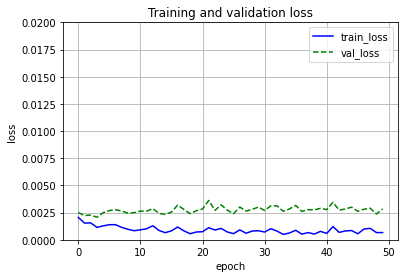

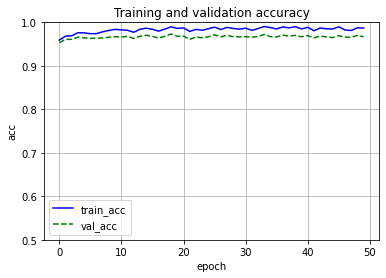

In [8]:
# plot graph
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), val_loss_list, color='green', linestyle='--', label='val_loss')
plt.ylim([0.0,0.02])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and validation loss')
plt.grid()
plt.savefig('MLP_mnist_loss.png')
plt.show()

plt.figure()
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), val_acc_list, color='green', linestyle='--', label='val_acc')
plt.ylim([0.5, 1.0])
plt.legend()
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and validation accuracy')
plt.grid()
plt.savefig('MLP_mnist_acc.png')
plt.show()